# Shot Party

The NBA api provides a lot of useful information about players and their shots. Let's use this to look at the specific characteristics of certain players.

First, let's import some libraries and useful building blocks.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from nba_api.stats.static import teams, players
from nba_api.stats.endpoints import shotchartdetail, commonplayerinfo

In [2]:
nba_teams = teams.get_teams()

steph = players.find_players_by_full_name('stephen curry')[0]
steph_info = commonplayerinfo.CommonPlayerInfo(player_id=steph['id'])

The next snippit of code from savvastjortjoglou draws the court on a plot.

In [3]:
# Credit: savvastjortjoglou
from matplotlib.patches import Circle, Rectangle, Arc

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)
    for element in court_elements:
        ax.add_patch(element)

    return ax

Some idiosyncracies of the `shotchartdetail` require us to not specify a team id or a month and ask specifically for all field goals attempted (FGA).
We also want to look at specifically the `Shot_Chart_Detail` record.

In [4]:
steph_array = np.array(shotchartdetail.ShotChartDetail(player_id=steph['id'],
                                                       team_id=0,
                                                       month=0,
                                                       context_measure_simple="FGA",
                                                       season_nullable='2018-19')
                       .get_normalized_dict()['Shot_Chart_Detail'])

In [5]:
print(len(steph_array))
print(steph_array[0])

1281
{'GRID_TYPE': 'Shot Chart Detail', 'GAME_ID': '0021800002', 'GAME_EVENT_ID': 10, 'PLAYER_ID': 201939, 'PLAYER_NAME': 'Stephen Curry', 'TEAM_ID': 1610612744, 'TEAM_NAME': 'Golden State Warriors', 'PERIOD': 1, 'MINUTES_REMAINING': 11, 'SECONDS_REMAINING': 31, 'EVENT_TYPE': 'Made Shot', 'ACTION_TYPE': 'Step Back Jump shot', 'SHOT_TYPE': '3PT Field Goal', 'SHOT_ZONE_BASIC': 'Above the Break 3', 'SHOT_ZONE_AREA': 'Right Side Center(RC)', 'SHOT_ZONE_RANGE': '24+ ft.', 'SHOT_DISTANCE': 24, 'LOC_X': 226, 'LOC_Y': 90, 'SHOT_ATTEMPTED_FLAG': 1, 'SHOT_MADE_FLAG': 1, 'GAME_DATE': '20181016', 'HTM': 'GSW', 'VTM': 'OKC'}


There's a lot of information out there but let's sort it into more useful values.

Let's create a boolean mask which will help us select items from the list. The api gives us a record `SHOT_MADE_FLAG` that is `1` when that specific shot scores. So we can create an array of booleans the same size (sometimes referred to as "shape" within numpy) where each value represents if that shot at that index made it in.

Once we have that it's easy to take advantage of numpy's indexing features to select the values we want from the larger array.

In [6]:
madeShotMask = np.array([item['SHOT_MADE_FLAG'] == 1 for item in steph_array])

madeShots = steph_array[madeShotMask]
missedShots = steph_array[~madeShotMask]

In [7]:
made_shotLocations = np.array([[shot['LOC_X'],shot['LOC_Y']] for shot in madeShots])
missed_shotLocations = np.array([[shot['LOC_X'],shot['LOC_Y']] for shot in missedShots])

Well now we have data, let's plot it

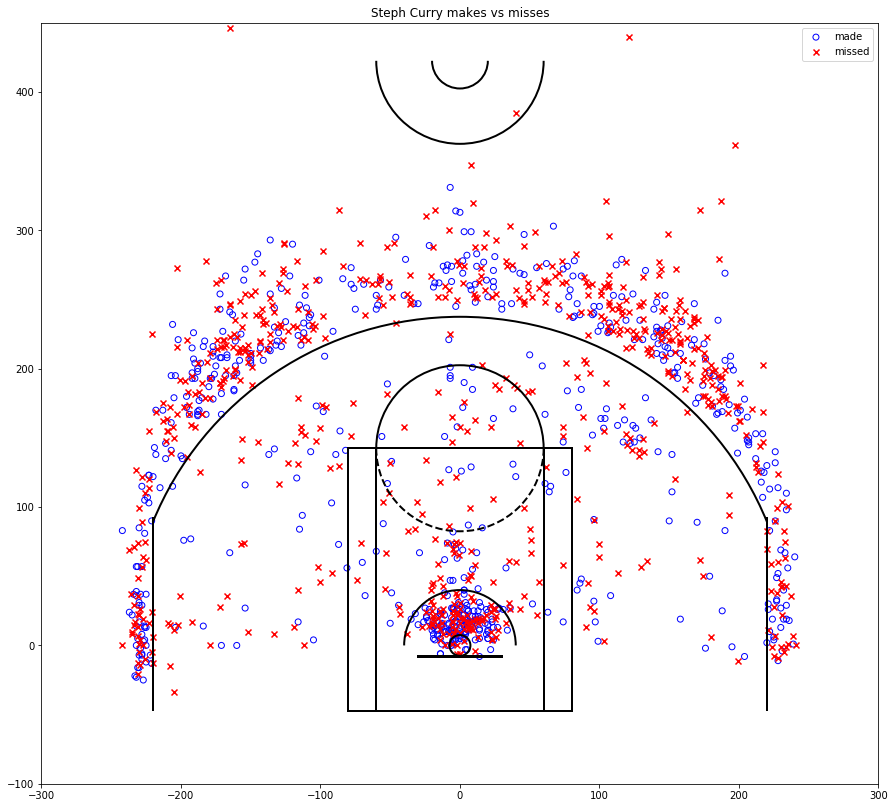

In [8]:
fig = plt.figure(figsize=(15,14))
ax = fig.add_subplot(111)

draw_court(ax)

ax.scatter(made_shotLocations[:,0],made_shotLocations[:,1],
           label="made", 
           facecolors='none', 
           edgecolors='b')

ax.scatter(missed_shotLocations[:,0],missed_shotLocations[:,1],
           color="r",
           label="missed", 
           marker="x")

ax.legend()

plt.title("Steph Curry makes vs misses")
plt.xlim(-300,300)
plt.ylim(-100,450)
plt.show()

This is a lot of information and it's quite difficult to read, let's try sorting the data into bins and highlight areas better.

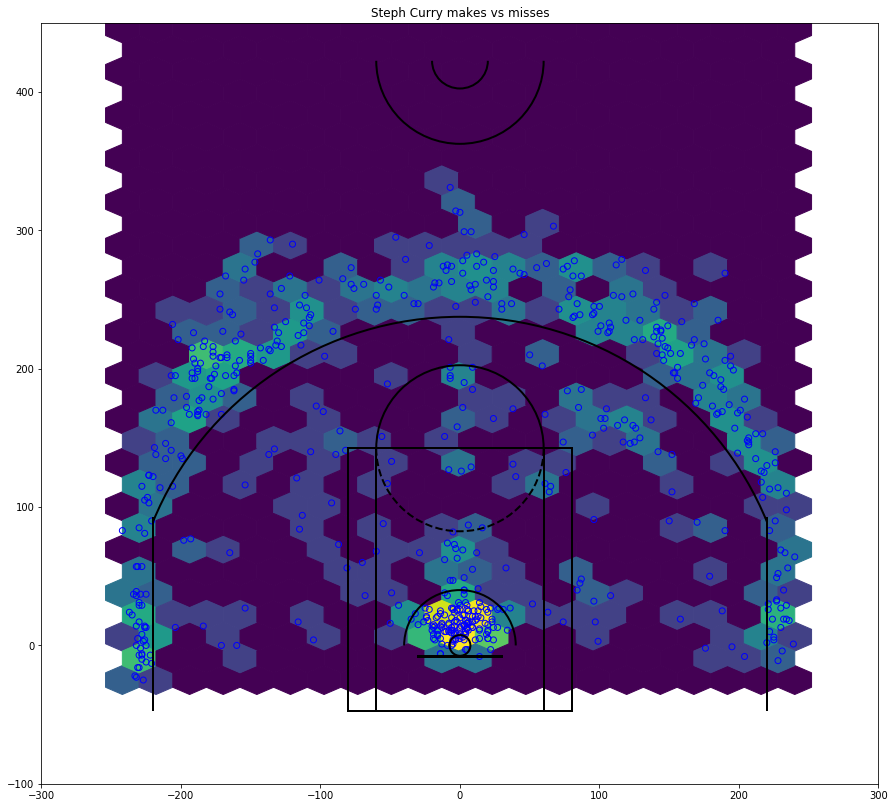

In [34]:
fig = plt.figure(figsize=(15,14))
ax = fig.add_subplot(111)

draw_court(ax)

ax.hexbin(made_shotLocations[:,0],made_shotLocations[:,1],
          gridsize=(20,20),
          bins='log'
         )

ax.scatter(made_shotLocations[:,0],made_shotLocations[:,1],
           label="made", 
           facecolors='none', 
           edgecolors='b'
          )

plt.title("Steph Curry makes vs misses")
plt.xlim(-300,300)
plt.ylim(-100,450)
plt.show()

Looks better and easier to understand, but it's still kinda messy. There are some dense areas but there are also some sparse areas, let's use KDE (Kernel Density Estimation) to see where the dense and sparse areas are

In [30]:
from scipy.stats import gaussian_kde

In [31]:
def density_helper(x,y):
    k = gaussian_kde(np.vstack([x, y]))
    xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    return (xi,yi,zi)

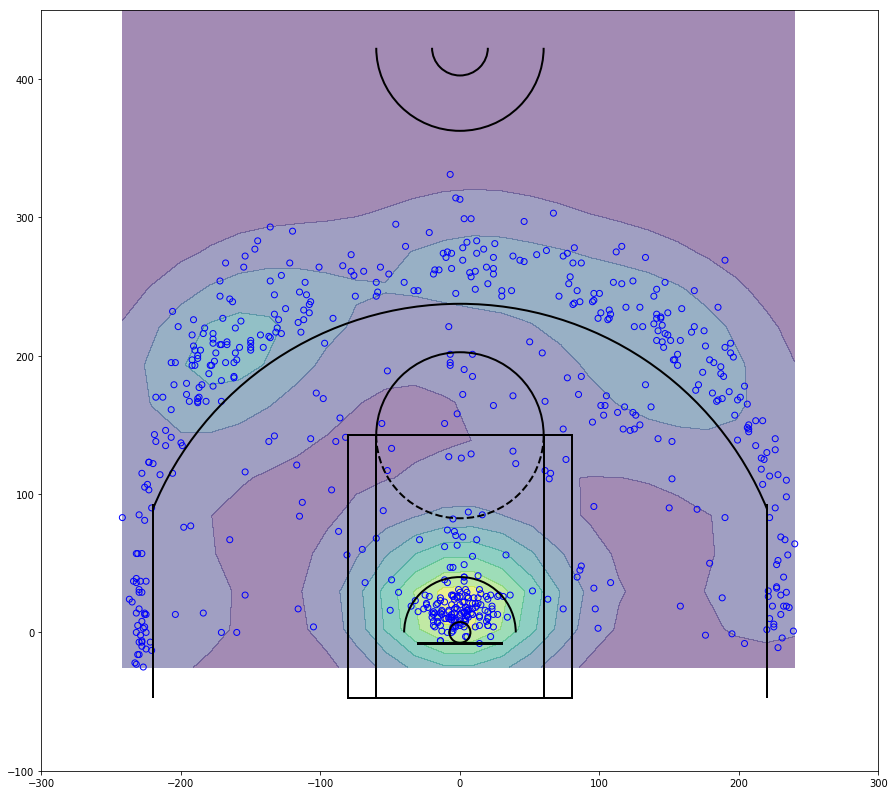

In [35]:
# Calculate the point density
xy = np.vstack([made_shotLocations[:,0],made_shotLocations[:,1]])
z = gaussian_kde(xy)(xy)

xi,yi,zi = density_helper(made_shotLocations[:,0],made_shotLocations[:,1])

fig = plt.figure(figsize=(15,14))
ax = fig.add_subplot(111)

ax.contourf(xi, yi, zi.reshape(xi.shape), alpha=0.5)

ax.set_xlim(made_shotLocations[:,0].min(), made_shotLocations[:,0].max())
ax.set_ylim(made_shotLocations[:,1].min(), made_shotLocations[:,1].max())

draw_court(ax)
ax.scatter(made_shotLocations[:,0],made_shotLocations[:,1],
           facecolors='none', 
           edgecolors='b'
          )

plt.xlim(-300,300)
plt.ylim(-100,450)
plt.show()

We see some really interesting information, some hot spots around the three point line, basically no man's land for the mid-range, and then dense concentric rings around the basket especially in the restricted area.